<a href="https://colab.research.google.com/github/Frank1497/SimpsonClassifier/blob/main/Simpons_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Frank1497/SimpsonClassifier.git

Cloning into 'SimpsonClassifier'...
remote: Enumerating objects: 20547, done.
remote: Total 20547 (delta 0), reused 0 (delta 0), pack-reused 20547
Receiving objects: 100% (20547/20547), 481.84 MiB | 30.16 MiB/s, done.
Checking out files: 100% (20539/20539), done.


In [ ]:
!ls SimpsonClassifier/simpsons

test  train


In [ ]:
import os
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_size = 32

**DATA PREPROCESSING**

CREATING TRAIN DATA WITH DATA AUGMENTATION

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'SimpsonClassifier/simpsons/train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   shear_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True
                                   )

#Creating Batch Size
train_generator = train_datagen.flow_from_directory(train_dir , batch_size=20, target_size=(img_size, img_size))

Found 19548 images belonging to 20 classes.


CREATING VALIDATION DATA WITH DATA AUGMENTATION

In [ ]:
validation_dir = 'SimpsonClassifier/simpsons/test'

validation_datatgen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datatgen.flow_from_directory(validation_dir , batch_size=20, target_size=(img_size, img_size))

Found 990 images belonging to 20 classes.


In [ ]:
label_map = train_generator.class_indices
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
label_map

{0: 'abraham_grampa_simpson',
 1: 'apu_nahasapeemapetilon',
 2: 'bart_simpson',
 3: 'charles_montgomery_burns',
 4: 'chief_wiggum',
 5: 'comic_book_guy',
 6: 'edna_krabappel',
 7: 'homer_simpson',
 8: 'kent_brockman',
 9: 'krusty_the_clown',
 10: 'lenny_leonard',
 11: 'lisa_simpson',
 12: 'marge_simpson',
 13: 'mayor_quimby',
 14: 'milhouse_van_houten',
 15: 'moe_szyslak',
 16: 'ned_flanders',
 17: 'nelson_muntz',
 18: 'principal_skinner',
 19: 'sideshow_bob'}

**BUILDING MODEL**

In [ ]:
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input
num_classes = len(label_map)

Importing vgg16 and Inspecting Layers

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (img_size, img_size, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding = "same", input_shape = (img_size, img_size, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                        

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("simpons_checkpointmodel.h5",
                             monitor='val_loss',
                             mode='min',
                             verbose=0,
                             save_best_only=True,
                             )

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.001,
                              )

callbacks = [checkpoint, earlystop, reduce_lr]

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='accuracy')

train_samples = 19548 
validation_samples = 990

history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.n // train_generator.batch_size, 
                    validation_data=validation_generator, 
                    validation_steps=validation_generator.n // validation_generator.batch_size, 
                    epochs=50,
                    shuffle=1,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
977/977 [==============================] - 112s 82ms/step - loss: 2.7662 - accuracy: 0.2483 - val_loss: 1.8642 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 2/50
977/977 [==============================] - 80s 82ms/step - loss: 1.7569 - accuracy: 0.4708 - val_loss: 1.2655 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 3/50
977/977 [==============================] - 80s 82ms/step - loss: 1.2920 - accuracy: 0.6100 - val_loss: 1.0379 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 4/50
977/977 [==============================] - 79s 81ms/step - loss: 1.0266 - accuracy: 0.6955 - val_loss: 1.3534 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 5/50
977/977 [==============================] - 79s 81ms/step - loss: 0.8390 - accuracy: 0.7536 - val_loss: 0.7611 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 6/50
977/977 [==============================] - 79s 81ms/step - loss: 0.7465 - accuracy: 0.7851 - val_loss: 0.6422 - val_accuracy: 0.8051 - lr: 0.0010
Epoch 7/50
977/977 [==============================] - 79s

In [ ]:
model.save('simpsons_model.h5')

Text(0.5, 0, 'epoch')

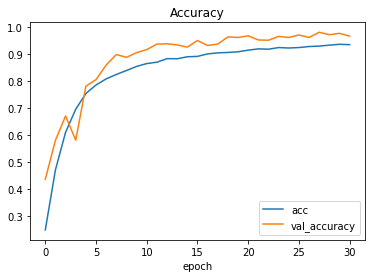

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

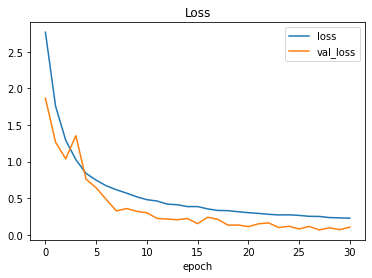

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

**Uploading Test File**

In [ ]:
!unrar x -Y "/content/drive/MyDrive/data/Simpons Test.rar"

In [ ]:
test_dir = '/content/Simpons Test'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                      target_size=(img_size, img_size), 
                                                      batch_size=batch_size, 
                                                      shuffle = False)

Found 990 images belonging to 20 classes.


**Plotting Confusion Matrix and Checking Classifiaction Report**

In [ ]:
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=-1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

labels = [label_map[i] for i in range(len(label_map))]
y_true = [label_map[i] for i in validation_generator.classes]
y_pred = [label_map[i] for i in predictions]

report = classification_report(y_true, y_pred, labels=labels)
cm = confusion_matrix(y_true, y_pred, labels=labels)

print(report)
print(cm)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.96      0.97        48
  apu_nahasapeemapetilon       0.98      1.00      0.99        50
            bart_simpson       0.96      0.96      0.96        50
charles_montgomery_burns       0.96      0.92      0.94        48
            chief_wiggum       0.96      1.00      0.98        50
          comic_book_guy       0.98      0.98      0.98        49
          edna_krabappel       1.00      0.98      0.99        50
           homer_simpson       0.94      0.96      0.95        50
           kent_brockman       1.00      1.00      1.00        50
        krusty_the_clown       0.98      1.00      0.99        50
           lenny_leonard       1.00      0.98      0.99        50
            lisa_simpson       0.98      0.98      0.98        50
           marge_simpson       0.98      1.00      0.99        50
            mayor_quimby       0.98      0.98      0.98        50
     milh

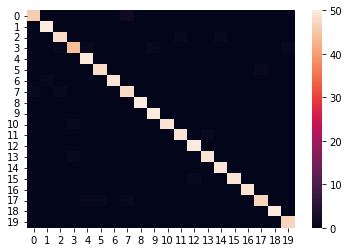

In [ ]:
import seaborn as sn
hm = sn.heatmap(data= cm)

In [ ]:
score = model.evaluate_generator(test_generator, verbose=1)
print('Test Score = ', score[0])
print('Test Accuracy = ', score[1])

 4/50 [=>............................] - ETA: 1s - loss: 0.0907 - accuracy: 0.9750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


50/50 [==============================] - 1s 22ms/step - loss: 0.0667 - accuracy: 0.9808
Test Score =  0.06668137013912201
Test Accuracy =  0.9808080792427063
